In [2]:
import numpy as np
import astropy.units as u
import yaml
import h5py
from astropy.constants import G
import os.path
import sys
from argparse import ArgumentParser
import pathlib
from mwlmc import model as mwlmc_model
Model = mwlmc_model.MWLMC()

from scipy.spatial.transform import Rotation
import scipy
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp

from gala.units import galactic
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


In [2]:
# def plummer_force(r, m, b):
#     """
#     plummer_force -  Returns the force of a Plummer sphere
    
#     Inputs:
#     - r: distance to compute force at from centre of potenial [kpc]
#     - m: mass [Msolar]
#     - b: scale radius [kpc]
    
#     Outputs:
#     - force in km^2 / (s^2 * kpc) - same as Lilleengen+23 simulations 
#     """
    
#     newG = G.to(u.kpc / u.Msun * (u.km/u.s)**2)
#     dpot_dr = (newG * m*u.Msun * r*u.kpc) / ((r*u.kpc)**2 + (b*u.kpc)**2)**1.5
#     force = -dpot_dr
#     return force 

In [50]:
def num_summedforces(t, progxs, mwdharmonicflag, mwhharmonicflag, lmcharmonicflag, motion):
    
    x0 = np.array(Model.expansion_centres(t))
    if motion==False:
        x0 *= 0 
    # disk 
    acc_disk = Model.mwd_fields(t, 
                                progxs[0, None].value - x0[:3][0, None],
                                progxs[1, None].value - x0[:3][1, None],
                                progxs[2, None].value - x0[:3][2, None],
                                mwdharmonicflag)[ :3]
    # halo
    acc_halo = Model.mwhalo_fields(t, 
                                   progxs[0, None].value - x0[3:6][0, None],
                                   progxs[1, None].value - x0[3:6][1, None],
                                   progxs[2, None].value - x0[3:6][2, None],
                                   mwhharmonicflag)[ :3]
    # lmc
    acc_lmc = Model.lmc_fields(t, 
                               progxs[0, None].value - x0[6:9][0, None],
                               progxs[1, None].value - x0[6:9][1, None],
                               progxs[2, None].value - x0[6:9][2, None],
                               lmcharmonicflag)[ :3]

    accs = (acc_disk + acc_halo + acc_lmc) * (u.km**2/(u.s**2*u.kpc))
    
    return accs

In [51]:
def numerical_forceDerivs(positions, t, mwhflag, mwdflag, lmcflag, motion, epsilon=1e-4):
    
    """
    numerical_forceDerivs - takes the positions for the mock stream progenitor and returns the derivatives of the forces for each position 
                    and second derivative of the potential w.r.t the positons.
    
    Inputs
    - positions: The positions of the progenitor in kpc, Shape N x 3.
    - ts: Time steps corresponding to each position in Gyr.
    - mwhflag: flag to set which mw halo expansion orders to be non-zero.
    - mwdflag: flag to set which mw disc expansion orders to be non-zero.
    - lmcflag: flag to set which lmc halo expansion orders to be non-zero.
    - epsilon: (optional) The small value away from each position used find the derivative in kpc. Default is 0.01pc
    
    Retuns
    - Hess: The Hessian matrix of all force derivatives. Shape (len(times), 3, 3). ((xx, xy, xz), 
                                                                                    (yx, yy, yz), 
                                                                                    (zx, zy, zz))
    - d2Phi_d2r: The second derivative of the potential with repect to the position.
    """
    
    r_prog = np.linalg.norm(positions)
    
    fxx_yx_zx = np.zeros(shape=(1,3))
    fxy_yy_zy = np.zeros(shape=(1,3))
    fxz_yz_zz = np.zeros(shape=(1,3))
    
    positions *= u.kpc
    positions_dx = (positions + np.array([epsilon,0.,0.])*u.kpc )
    positions_dy = (positions + np.array([0.,epsilon,0.])*u.kpc )
    positions_dz = (positions + np.array([0.,0.,epsilon])*u.kpc )
    
    fxx_yx_zx = (num_summedforces(t, positions_dx, mwdflag, mwhflag, lmcflag, motion) - num_summedforces(t, positions, mwdflag, mwhflag, lmcflag, motion) ) \
                    / np.linalg.norm(positions_dx - positions)
        
    fxy_yy_zy = (num_summedforces(t, positions_dy, mwdflag, mwhflag, lmcflag, motion) - num_summedforces(t, positions, mwdflag, mwhflag, lmcflag, motion) ) \
                    / np.linalg.norm(positions_dy - positions)
        
    fxz_yz_zz = (num_summedforces(t, positions_dz, mwdflag, mwhflag, lmcflag, motion) - num_summedforces(t, positions, mwdflag, mwhflag, lmcflag, motion) ) \
                    / np.linalg.norm(positions_dz - positions)
        
    Hess = np.zeros((1, 3, 3))
    Hess[:, 0, :] = -np.array([fxx_yx_zx[:, 0], fxy_yy_zy[:, 0], fxz_yz_zz[:, 0]]).T
    Hess[:, 1, :] = -np.array([fxx_yx_zx[:, 1], fxy_yy_zy[:, 1], fxz_yz_zz[:, 1]]).T
    Hess[:, 2, :] = -np.array([fxx_yx_zx[:, 2], fxy_yy_zy[:, 2], fxz_yz_zz[:, 2]]).T
    
    r_hat = positions.reshape(1,3) / r_prog.reshape(1,)
    d2Phi_d2r = np.einsum('ki,kij,kj->k', r_hat, Hess, r_hat)
    
    return d2Phi_d2r.value*(u.km**2/(u.s**2*u.kpc**2))
    
def fill_with_zeros(arr, m):
    n = arr.shape[0]
    if m <= n:
        return arr
    else:
        filled_arr = np.full((m, 3), np.nan)
        filled_arr[:n, :] = arr
        return filled_arr
    
def fill_with_nans_1d(arr, m):
    n = arr.shape[0]
    if m <= n:
        return arr
    else:
        filled_arr = np.full(m, np.nan)
        filled_arr[:n] = arr
        return filled_arr
    
def harmonicflags_to_potlabel(mwhflag, mwdflag, lmcflag, mwh_static):
    
    if mwhflag==0 and mwh_static==True and mwdflag==63 and lmcflag==63:
        label = 'rm-MWhalo-full-MWdisc-full-LMC'
    
    elif mwhflag==0 and mwh_static==False and mwdflag==63 and lmcflag==63:
        label = 'em-MWhalo-full-MWdisc-full-LMC'
    
    elif mwhflag==1 and mwdflag==63 and lmcflag==63:
        label = 'md-MWhalo-full-MWdisc-full-LMC'
        
    elif mwhflag==2 and mwdflag==63 and lmcflag==63:
        label = 'mq-MWhalo-full-MWdisc-full-LMC'
        
    elif mwhflag==3 and mwdflag==63 and lmcflag==63:
        label = 'mdq-MWhalo-full-MWdisc-full-LMC'
        
    elif mwhflag==63 and mwdflag==63 and lmcflag==63:
        label = 'Full-MWhalo-MWdisc-LMC'
        
    elif mwhflag==63 and mwdflag==63 and lmcflag==0:
        label = 'full-MWhalo-full-MWdisc-no-LMC'
        
    elif mwhflag==0 and mwdflag==0 and lmcflag==0:
        label = 'static-mwh-only'
      
    return label

In [41]:
# def rewind_leap(fc_xs, fc_vs, mwhharmonicflag, mwdharmonicflag, lmcharmonicflag, Tend, dt):
    
#     max_steps = int((np.abs(Tend) - 0.) / dt) + 2
#     xs_orbit = np.zeros(shape=(max_steps,3))*u.kpc
#     vs_orbit = np.zeros(shape=(max_steps,3))*(u.km/u.s) 
    
#     mwd_x0 = np.array(Model.expansion_centres(0.)[:3])*u.kpc
#     mwd_v0 = np.array(Model.expansion_centre_velocities(0.)[:3])*(u.km/u.s) 
    
#     prog_xs0 = (fc_xs+mwd_x0)
#     prog_vs0 = -(fc_vs+mwd_v0)
#     xs_orbit[0] = prog_xs0
#     vs_orbit[0] = prog_vs0

#     ts = np.array([0.])
#     t = ts[0] 
    
#     i=0
#     while t > Tend:
#         x0 = np.array(Model.expansion_centres(t))
#         # disk 
#         acc_disk = Model.mwd_fields(t, 
#                                     xs_orbit[i][0, None].value - x0[:3][0, None],
#                                     xs_orbit[i][1, None].value - x0[:3][1, None],
#                                     xs_orbit[i][2, None].value - x0[:3][2, None],
#                                     mwdharmonicflag)[:, :3]
#         # halo
#         acc_halo = Model.mwhalo_fields(t, 
#                                        xs_orbit[i][0, None].value - x0[3:6][0, None],
#                                        xs_orbit[i][1, None].value - x0[3:6][1, None],
#                                        xs_orbit[i][2, None].value - x0[3:6][2, None],
#                                        mwhharmonicflag)[:, :3]
#         # lmc
#         acc_lmc = Model.lmc_fields(t, 
#                                    xs_orbit[i][0, None].value - x0[6:9][0, None],
#                                    xs_orbit[i][1, None].value - x0[6:9][1, None],
#                                    xs_orbit[i][2, None].value - x0[6:9][2, None],
#                                    lmcharmonicflag)[:, :3]

#         accs = (acc_disk + acc_halo + acc_lmc) * (u.km**2/(u.s**2*u.kpc))
        
#         xs_orbit[i+1] = xs_orbit[i] + (vs_orbit[i] * (dt*u.Gyr).to(u.s)).to(u.kpc) + (0.5 * accs * ((dt*u.Gyr).to(u.s))**2).to(u.kpc)
#         ts = np.append(ts, t - dt)
#         t = t - dt
        
#         x0 = np.array(Model.expansion_centres(t))
#         new_acc_disk = Model.mwd_fields(t, 
#                                     xs_orbit[i+1][0, None].value - x0[:3][0, None],
#                                     xs_orbit[i+1][1, None].value - x0[:3][1, None],
#                                     xs_orbit[i+1][2, None].value - x0[:3][2, None],
#                                     mwdharmonicflag)[:, :3]
#         # halo
#         new_acc_halo = Model.mwhalo_fields(t, 
#                                        xs_orbit[i+1][0, None].value - x0[3:6][0, None],
#                                        xs_orbit[i+1][1, None].value - x0[3:6][1, None],
#                                        xs_orbit[i+1][2, None].value - x0[3:6][2, None],
#                                        mwhharmonicflag)[:, :3]
#         # lmc
#         new_acc_lmc = Model.lmc_fields(t, 
#                                    xs_orbit[i+1][0, None].value - x0[6:9][0, None],
#                                    xs_orbit[i+1][1, None].value - x0[6:9][1, None],
#                                    xs_orbit[i+1][2, None].value - x0[6:9][2, None],
#                                    lmcharmonicflag)[:, :3]

#         new_accs = (new_acc_disk + new_acc_halo + new_acc_lmc) * (u.km**2/(u.s**2*u.kpc))
        
#         vs_orbit[i+1] = vs_orbit[i] + (0.5 * (accs + new_accs) * (dt*u.Gyr).to(u.s)).to(u.km/u.s)
        
#         i += 1
#     mask = np.all(xs_orbit==0, axis=(1)) 
    
#     for i in range(len(xs_orbit)):
#         disk_x0 = np.array(Model.expansion_centres(ts[i])[:3])
#         disk_v0 = np.array(Model.expansion_centre_velocities(ts[i])[:3])
#         xs_orbit[i] -= disk_x0 * u.kpc
#         vs_orbit[i] -= disk_v0 * u.km/u.s
    
#     return xs_orbit[~mask], vs_orbit[~mask], ts

In [42]:
def gala_F(t, w, mwdflag, mwhflag, lmcflag, motion):
    t = t / 1e3  # Myr -> Gyr
    x0 = np.array(Model.expansion_centres(t))
    if motion==False:
        x0 *= 0 
    # disk
    acc_disk = Model.mwd_fields(t, *(w[:3, :] - x0[:3, None]), mwdharmonicflag=mwdflag)[:, :3]
    # MiyamotoNagai = gp.MiyamotoNagaiPotential(6.8e10*u.Msun, 3*u.kpc, 0.28*u.kpc, units=galactic, origin=x0[:3])
    # acc_disk = MiyamotoNagai.acceleration(w[:3, :] - x0[:3, None]).to((u.km**2/(u.s**2*u.kpc))).value.T
    # halo
    acc_halo = Model.mwhalo_fields(t, *(w[:3] - x0[3:6, None]), mwhharmonicflag=mwhflag)[:, :3]
    # lmc
    acc_lmc = Model.lmc_fields(t, *(w[:3] - x0[6:9, None]), lmcharmonicflag=lmcflag)[:, :3]
    
    accs = (acc_disk + acc_halo + acc_lmc) * (u.km**2/(u.s**2*u.kpc))
    accs = accs.decompose(galactic).value
    return np.vstack((w[3:], accs.T))

# def F_rigid(t, w, m200, c200):
#         origin_halo = np.array(Model.expansion_centres(t/1e3))[3:6]
#         pot = gp.NFWPotential.from_M200_c(M200=m200*u.Msun, c=c200, units=galactic, origin=origin_halo)   
#         wdot = np.zeros_like(w)
#         wdot[3:] = pot.acceleration(w[:3]).value    
#         wdot[:3] = w[3:]
#         return wdot

def gala_rewind(Tbegin, Tend, dt, w, mwdflag, mwhflag, lmcflag, motion):
    
    # integrator = gi.LeapfrogIntegrator(F_rigid, func_units=galactic, func_args=(6.5e11, 25,))
    integrator = gi.LeapfrogIntegrator(gala_F, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag, motion))
    # integrator = gi.Ruth4Integrator(gala_F, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag,))
    
    mwd_x0 = np.array(Model.expansion_centres(0.)[:3])*u.kpc 
    mwd_v0 = np.array(Model.expansion_centre_velocities(0.)[:3])*(u.km/u.s) 
    if motion==False:
        mwd_x0 *= 0
        mwd_v0 *= 0
    
    w0 = gd.PhaseSpacePosition(pos=w.xyz + mwd_x0,
                               vel=(w.v_xyz.to(u.km/u.s) + mwd_v0).to(u.kpc/u.Myr) )
    orbit = integrator.run(w0, dt=-dt*u.Myr, t1=Tend*u.Gyr, t2=Tbegin*u.Gyr)
    # print(orbit.pericenter(), orbit.apocenter())
    # orbit_no_corr = gd.Orbit(pos=orbit.xyz,vel=orbit.v_xyz,t=orbit.t)
    # orbit_no_corr.plot();
    
    # subtract these off
    disk_x0 = np.array([Model.expansion_centres(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    disk_v0 = np.array([Model.expansion_centre_velocities(t)[:3] for t in orbit.t.to_value(u.Gyr)])    
    if motion==False:
        disk_x0 *= 0
        disk_v0 *= 0
    pos=orbit.xyz - disk_x0.T*u.kpc,
    vel=orbit.v_xyz.to(u.km/u.s) - disk_v0.T*u.km/u.s,
    t=orbit.t
    return pos[0].to(u.kpc), vel[0].to(u.km/u.s), t.to(u.Gyr)

In [43]:
def gala_forward(Tbegin, Tend, dt, w, mwdflag, mwhflag, lmcflag, motion):
    
    integrator = gi.LeapfrogIntegrator(gala_F, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag,motion))
    # integrator = gi.Ruth4Integrator(gala_F, func_units=galactic, func_args=(mwdflag, mwhflag, lmcflag,))
    
    mwd_x0 = np.array(Model.expansion_centres(Tbegin)[:3])*u.kpc 
    mwd_v0 = np.array(Model.expansion_centre_velocities(Tbegin)[:3])*(u.km/u.s) 
    if motion==False:
        mwd_x0 *= 0
        mwd_v0 *= 0
    
    w0 = gd.PhaseSpacePosition(pos=w.xyz+mwd_x0,
                               vel=(w.v_xyz.to(u.km/u.s) +mwd_v0).to(u.kpc/u.Myr) )

    orbit = integrator.run(w0, dt=dt, t1=Tbegin*u.Gyr, t2=Tend)
    print(orbit.pericenter(), orbit.apocenter())
    # orbit_no_corr = gd.Orbit(pos=orbit.xyz,vel=orbit.v_xyz,t=orbit.t)
    # orbit_no_corr.plot();
    
    # subtract these off
    disk_x0 = np.array([Model.expansion_centres(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    disk_v0 = np.array([Model.expansion_centre_velocities(t)[:3] for t in orbit.t.to_value(u.Gyr)]) 
    if motion==False:
        disk_x0 *= 0
        disk_v0 *= 0
    pos=orbit.xyz - disk_x0.T*u.kpc,
    vel=orbit.v_xyz.to(u.km/u.s) - disk_v0.T*u.km/u.s,
    t=orbit.t
    
#     orbit_disk_frame = gd.Orbit(pos=orbit.xyz - disk_x0.T*u.kpc,vel=orbit.v_xyz - disk_v0.T*u.km/u.s,t=orbit.t)
#     orbit_disk_frame.plot();
    return pos[0].to(u.kpc), vel[0].to(u.km/u.s), t.to(u.Gyr)

In [44]:
def energies_angmom(t, xs, vs, mwdflag, mwhflag, lmcflag, motion):
    
    """
    calculate the energies and angular momenta of particles for a given time snapshot.
    """
    # Kinetic energy
    Ek = (.5 * np.linalg.norm(vs, axis=1)**2) * (u.km/u.s)**2
    # Potential energy
    x0 = np.array(Model.expansion_centres(t))
    if motion==False:
        x0 *= 0 
    pot_disk = Model.mwd_fields(t, 
                                xs[:,0] - x0[:3][0],
                                xs[:,1] - x0[:3][1],
                                xs[:,2] - x0[:3][2],
                                mwdflag)[:,4]
    pot_halo = Model.mwhalo_fields(t, 
                                   xs[:,0] - x0[3:6][0],
                                   xs[:,1] - x0[3:6][1],
                                   xs[:,2] - x0[3:6][2],
                                   mwhflag)[:,4]
    pot_lmc = Model.lmc_fields(t, 
                               xs[:,0] - x0[6:9][0],
                               xs[:,1] - x0[6:9][1],
                               xs[:,2] - x0[6:9][2],
                               lmcflag)[:,4]
    Ep = (pot_disk + pot_halo + pot_lmc) * (u.km/u.s)**2
    E = Ek + Ep
    # Angular momentum
    L = np.linalg.norm(np.cross(xs, vs), axis=1) * (u.kpc*u.km/u.s)
    Lz = np.cross(xs[:,0:2], vs[:,0:2]) * (u.kpc*u.km/u.s)
    Lx = np.cross(xs[:,1:], vs[:,1:]) * (u.kpc*u.km/u.s)
    
    return E, L, Lz, Lx

In [45]:
def lmc_traj(rewindtime, dt):
    """
    Find the past orbit of the lmc in the inertial frame
    """
    
    # Returned lmc trajectory in the frame of the MW disc.
    txyz = Model.get_lmc_trajectory(rewindtime, dt)
    ts, xyz = txyz[:,0], txyz[:,1:]
    # Correct for the MW disc COM. Places the rewind in the inertial (box) frame.
    for i in range(len(ts)):
        disc0 = np.array(Model.expansion_centres(ts[i]))[:3]
        xyz[i] = xyz[i] - disc0
    
    rlmc = np.linalg.norm(xyz, axis=1)
        
    return ts, xyz, rlmc

In [46]:
def orbpole(xs,vs):
    uu = np.cross(xs, vs, axis=1)
    uumag = np.linalg.norm(uu, axis=1)
    u = uu.T/uumag
    b = np.arcsin(u[2])
    sinl = u[1]/np.cos(b)
    cosl = u[0]/np.cos(b)
    ll = np.arctan2(sinl, cosl)
    gl = np.degrees(ll)
    gb = np.degrees(b)
    return gl, gb   

In [60]:
def lagrange_cloud_strip_adT(params):  
    
    inpath, snapname, outpath, filename, \
    fc, Mprog, a_s, pericenter, apocenter, Tbegin, Tfinal, dtmin, \
    mwhflag, mwdflag, lmcflag, strip_rate, \
    static_mwh, static_mwd, lmc_switch, motion = params

    new_G = G.to(u.kpc*(u.km/u.s)**2/u.Msun)
    Lunits = (u.kpc*u.km)/u.s
    lambda_source = 1. # the multiplier of how far away from the tidal radius to strip from.
    max_steps = int((Tfinal - Tbegin) / dtmin) + 2 
    max_particles = int( ((max_steps)*strip_rate) + 1)
    
    if static_mwh==True:
        _, MWHcoeffs = Model.return_mw_coefficients()
        MWHcoeffs = np.array(MWHcoeffs)
        MWHcoeffs[:,0] = MWHcoeffs[:,0][0] 
        MWHcoeffs[:,1:] = MWHcoeffs[:,1:]*0
        Model.install_mw_coefficients(MWHcoeffs)
        #Some line of code here to check they have been set to zero and reinstalled
        _, MWHcoeffs = Model.return_mw_coefficients()
        assert np.allclose(np.array(MWHcoeffs)[:,1:],0)==True, "MW halo coefficients need to be set to zero"
        
    if static_mwd==True:
        MWDfloats, MWDctmp, MWDstmp = Model.return_disc_coefficients()
        MWDctmp, MWDstmp = np.array(MWDctmp), np.array(MWDstmp)
        # MWDctmp[:,0], MWDstmp[:,0] = MWDctmp[:,0][0], MWDstmp[:,0][0]
        MWDctmp[:,0], MWDstmp[:,0] = MWDctmp[:,0][0]*0, MWDstmp[:,0][0]*0
        MWDctmp[:,1:], MWDstmp[:,1:] = MWDctmp[:,1:]*0, MWDstmp[:,1:]*0
        Model.install_disc_coefficients(MWDctmp,MWDstmp)
        #Some line of code here to check they have been set to zero and reinstalled.
        MWDfloats, MWDctmp, MWDstmp = Model.return_disc_coefficients()
        assert np.allclose(np.array(MWDctmp)[:,1:],0)==True, "MW disc coefficients (c) need to be set to zero"
        assert np.allclose(np.array(MWDstmp)[:,1:],0)==True, "MW disc coefficients (s) need to be set to zero"
        
    if lmc_switch==True:
        _, LMCcoeffs = Model.return_lmc_coefficients()
        LMCcoeffs = np.array(LMCcoeffs)
        LMCcoeffs *= 0 
        Model.install_lmc_coefficients(LMCcoeffs)
        #Some line of code here to check they have been set to zero and reinstalled.
        _, LMCcoeffs = Model.return_lmc_coefficients()
        assert np.allclose(np.array(LMCcoeffs),0)==True, "LMC coefficients need to be set to zero"
    
    # prog_orbit = rewind_leap(fc[:3]*u.kpc, 
    #                          fc[3:6]*(u.km/u.s), 
    #                          mwhflag, 
    #                          mwdflag,
    #                          lmcflag, 
    #                          Tbegin,
    #                          dtmin)
    # print(fc[3:6]* (u.kpc/u.Myr), (fc[3:6] * (u.kpc/u.Myr)).to(u.km/u.s))
    w0 = gd.PhaseSpacePosition.from_w(fc.T, units=galactic)
    # w0 = gd.PhaseSpacePosition(pos=fc[:3]*u.kpc,vel=(fc[3:6] * (u.kpc/u.Myr)).to(u.km/u.s), units=galactic) 
    print('rewinding progenitor...')
    prog_orbit = gala_rewind(Tbegin, Tfinal, dtmin*u.Gyr.to(u.Myr), w0, mwdflag, mwhflag, lmcflag, motion)
    rewind_xs = prog_orbit[0].T #unpack tuple
    rewind_vs = prog_orbit[1].T #unpack tuple
    rewind_ts = prog_orbit[2]
    prog_ic = np.concatenate([rewind_xs[-1].value, rewind_vs[-1].value]).reshape(1,6)
    w_ic = gd.PhaseSpacePosition(pos=rewind_xs[-1],vel=rewind_vs[-1]) 
    
    xs_data = np.full(shape=(max_steps, max_particles, 3), fill_value=np.nan)
    vs_data = np.zeros(shape=(max_steps, max_particles, 3))
    ts = np.array([rewind_ts[-1].value])
    t = ts[0] 
    
    print('forward integrating...')
    xs_gala,vs_gala,ts_gala = gala_forward(Tbegin, Tfinal, dtmin*u.Gyr.to(u.Myr), w_ic, mwdflag, mwhflag, lmcflag, motion)

    disk_xf = np.array(Model.expansion_centres(t)[:3]) 
    disk_vf = np.array(Model.expansion_centre_velocities(t)[:3]) 
    if motion==False:
        disk_xf *= 0 
        disk_vf *= 0 
    xs = np.array(prog_ic[:,0:3])*u.kpc + disk_xf*u.kpc
    vs = np.array(prog_ic[:,3:6])*(u.km/u.s) +disk_vf*(u.km/u.s)
    
    i = 0
    while t < Tfinal:
        
        prog_xs = (xs[:, 0:3][0]).reshape(1,3).value
        prog_vs = (vs[:, 0:3][0]).reshape(1,3).value
     
        # Calculate inital angular speed of progenitor (in units of km/s/kpc)
        r_prog = np.linalg.norm(prog_xs[0:3])
        L_prog = np.linalg.norm(np.cross(prog_xs[0:3], prog_vs[0:3]))
        Omega_prog = L_prog*Lunits / (r_prog*u.kpc)**2
        r_hat = prog_xs[0:3]/r_prog
        num_d2Phi_dr2 = numerical_forceDerivs(prog_xs.reshape(3,), t, mwhflag, mwdflag, lmcflag, motion)

        # Calculate tidal radius
        mass_frac = 1 - (np.abs(Tbegin) - np.abs(t))/np.abs(Tbegin)
        rt = ((new_G * (Mprog*mass_frac)*u.Msun) / (Omega_prog**2 - num_d2Phi_dr2) )**(1/3) 
        r_t = np.nan_to_num(rt.value, nan=1) #kpc
        sigma_s = ((new_G.value * Mprog * mass_frac) / (r_t**2 + a_s**2)**0.5)**0.5

        # Calculate positions and velocities of points of particle release
        source_coords_in = prog_xs[0:3] - lambda_source * r_t[:, None] * r_hat
        source_coords_out = prog_xs[0:3] + lambda_source * r_t[:, None] * r_hat

        prog_velocity_r = np.sum(prog_vs[0:3]*r_hat)
        prog_velocity_tan = prog_vs[0:3] - prog_velocity_r * r_hat

        source_velocity_tan_in = prog_velocity_tan * (1 - 0.5 * r_t / r_prog)[:, None]
        source_velocity_tan_out = prog_velocity_tan * (1 + 0.5 * r_t / r_prog)[:, None]

        source_velocity_in = prog_velocity_r * r_hat + source_velocity_tan_in
        source_velocity_out = prog_velocity_r * r_hat + source_velocity_tan_out

        source_coords = np.zeros((len(source_coords_in)*2, 3))
        source_coords[::2] = source_coords_in
        source_coords[1::2] = source_coords_out

        source_velocity = np.zeros((len(source_velocity_in)*2, 3))
        source_velocity[::2] = source_velocity_in
        source_velocity[1::2] = source_velocity_out

        ic_source_coords = np.repeat(source_coords, strip_rate/2, axis=0)
        ic_source_velocities = np.repeat(source_velocity, strip_rate/2, axis=0)
 
        np.random.seed(0)
        xs = np.append(xs, ic_source_coords*u.kpc, axis=0)
        vs = np.append(vs, (ic_source_velocities + np.random.randn(len(ic_source_velocities), 3)*sigma_s)*(u.km/u.s), axis=0)
        
        #-----------------------------------------------------------------------------------------------------
        # LEAPFROG INTEGRATION 
        #-----------------------------------------------------------------------------------------------------
        x0 = np.array(Model.expansion_centres(t))
        if motion==False:
            x0 *= 0  
        # disk 
        acc_disk = Model.mwd_fields(t, 
                                    xs[:,0].value - x0[:3][0, None],
                                    xs[:,1].value - x0[:3][1, None],
                                    xs[:,2].value - x0[:3][2, None],
                                    mwdharmonicflag=mwdflag)[:, :3]
       
        # MiyamotoNagai = gp.MiyamotoNagaiPotential(6.8e10*u.Msun, 3*u.kpc, 0.28*u.kpc, units=galactic, origin=x0[:3])
        # acc_disk = MiyamotoNagai.acceleration((xs - x0[:3]*u.kpc).T).to((u.km**2/(u.s**2*u.kpc))).value.T  
        
        # halo
        acc_halo = Model.mwhalo_fields(t, 
                                       xs[:,0].value - x0[3:6][0, None],
                                       xs[:,1].value - x0[3:6][1, None],
                                       xs[:,2].value - x0[3:6][2, None],
                                       mwhharmonicflag=mwhflag)[:, :3]
        # lmc
        acc_lmc = Model.lmc_fields(t, 
                                   xs[:,0].value - x0[6:9][0, None],
                                   xs[:,1].value - x0[6:9][1, None],
                                   xs[:,2].value - x0[6:9][2, None],
                                   lmcharmonicflag=lmcflag)[:, :3]

        accs = (acc_disk + acc_halo + acc_lmc) * (u.km**2/(u.s**2*u.kpc))

        xs = xs + (vs * (dtmin*u.Gyr).to(u.s)).to(u.kpc) + (0.5 * accs * ((dtmin*u.Gyr).to(u.s))**2).to(u.kpc) 
        ts = np.append(ts, t+dtmin)
        t = t + dtmin

        x0 = np.array(Model.expansion_centres(t))
        if motion==False:
            x0 *= 0  
        new_acc_disk = Model.mwd_fields(t, 
                                    xs[:,0].value - x0[:3][0, None],
                                    xs[:,1].value - x0[:3][1, None],
                                    xs[:,2].value - x0[:3][2, None],
                                    mwdharmonicflag=mwdflag)[:, :3]
        # MiyamotoNagai = gp.MiyamotoNagaiPotential(6.8e10*u.Msun, 3*u.kpc, 0.28*u.kpc, units=galactic, origin=x0[:3])
        # new_acc_disk = MiyamotoNagai.acceleration((xs - x0[:3]*u.kpc).T).to((u.km**2/(u.s**2*u.kpc))).value.T                                      
                                              
        # halo
        new_acc_halo = Model.mwhalo_fields(t, 
                                       xs[:,0].value - x0[3:6][0, None],
                                       xs[:,1].value - x0[3:6][1, None],
                                       xs[:,2].value - x0[3:6][2, None],
                                       mwhharmonicflag=mwhflag)[:, :3]
        # lmc
        new_acc_lmc = Model.lmc_fields(t, 
                                   xs[:,0].value - x0[6:9][0, None],
                                   xs[:,1].value - x0[6:9][1, None],
                                   xs[:,2].value - x0[6:9][2, None],
                                   lmcharmonicflag=lmcflag)[:, :3]
   
        new_accs = (new_acc_disk + new_acc_halo + new_acc_lmc) * (u.km**2/(u.s**2*u.kpc))
    
        vs = vs + (0.5 * (accs + new_accs) * (dtmin*u.Gyr).to(u.s)).to(u.km/u.s)

        xs_data[i], vs_data[i] = fill_with_zeros(xs, max_particles), fill_with_zeros(vs, max_particles)

        i += 1
         
    mask = np.all(np.isnan(xs_data), axis=(1,2)) 
    xs_data = xs_data[~mask]
    vs_data = vs_data[~mask]
    ts2 = np.repeat(ts, strip_rate)

    for i in range(len(xs_data)):
            
        disk_x0 = np.array(Model.expansion_centres(ts[i])[:3])
        disk_v0 = np.array(Model.expansion_centre_velocities(ts[i])[:3]) 
        if motion==False:
            disk_x0 *= 0
            disk_v0 *= 0
        xs_data[i] -= disk_x0
        vs_data[i] -= disk_v0

    # Save only every 100th time snapshot - flipping to slice properly, flip back after
    xs_snaps = np.flip(np.flip(xs_data, axis=0)[::100], axis=0)
    vs_snaps = np.flip(np.flip(vs_data, axis=0)[::100], axis=0)
    ts_snaps = np.flip(np.flip(ts, axis=0)[::100])
    
    print("calculating energies, angular momenta, velocity dispersion, LMC separation, orbital poles...")
    Es = np.full(shape=(len(xs_snaps), max_particles), fill_value=np.nan)
    Ls = np.full(shape=(len(xs_snaps), max_particles), fill_value=np.nan)
    Lzs = np.full(shape=(len(xs_snaps), max_particles), fill_value=np.nan)
    Lxs = np.full(shape=(len(xs_snaps), max_particles), fill_value=np.nan)
    sigma_v = np.nanstd(np.linalg.norm(vs_snaps[-1], axis=1), axis=0)
    lmc_sep = np.full(shape=(len(xs_snaps), max_particles), fill_value=np.nan)
    gls  =  np.full(shape=(len(xs_snaps), max_particles), fill_value=np.nan)
    gbs  =  np.full(shape=(len(xs_snaps), max_particles), fill_value=np.nan)
    
    for i in range(len(xs_snaps)):
        Es[i], Ls[i], Lzs[i], Lxs[i] = energies_angmom(ts_snaps[i], xs_snaps[i], vs_snaps[i], mwdflag, mwhflag, lmcflag, motion)
        lmc_sep[i] = np.linalg.norm(Model.expansion_centres(ts_snaps[i])[6:9]) - np.linalg.norm(xs_snaps[i], axis=1)
        gls[i], gbs[i] = orbpole(xs_snaps[i], vs_snaps[i])
        
    print("calculating LMC closest approach...")
    lmc_close_sep = np.nanmin(lmc_sep, axis=0)
        
    # pot_label = harmonicflags_to_potlabel(mwhflag, mwdflag, lmcflag, static_mwh)    
    # write_stream_hdf5(outpath, filename, xs_snaps, vs_snaps, ts2,
    #                   Es, Ls, Lzs, sigma_v, lmc_close_sep, gls, gbs,
    #                   pot_label, fc, Mprog, a_s, 
    #                   pericenter, apocenter, discframe)
    
    # return xs_data[~mask], vs_data[~mask], ts2, tidal_radii, sigma_vs, prog_orbit
    return xs_gala,vs_gala,ts_gala,prog_orbit, xs_data, vs_data, ts2, Es, Ls, Lzs, Lxs, sigma_v, lmc_close_sep


def write_stream_hdf5(outpath, filename, positions, velocities, times, 
                      energies, Ls, Lzs, sigma_v, lmc_sep, gls, gbs,
                      potential, progics, progmass, progscale, 
                      pericenter, apocenter, frame):
    """
    Write stream into an hdf5 file
    
    """
    
    tmax = positions.shape[0]
    particlemax = positions.shape[1]
    
    print("* Writing stream: {}, for potential: {}".format(filename, potential))
    hf = h5py.File(outpath + filename + ".hdf5", 'w')
    hf.create_dataset('positions', data=positions, shape=(tmax, particlemax, 3))
    hf.create_dataset('velocities', data=velocities, shape=(tmax, particlemax, 3))
    hf.create_dataset('times', data=times)
    hf.create_dataset('energies', data=energies)
    hf.create_dataset('L', data=Ls)
    hf.create_dataset('Lz', data=Lzs)
    hf.create_dataset('vel_dispersion', data=sigma_v)
    hf.create_dataset('lmc_sep', data=lmc_sep)
    hf.create_dataset('pole_l', data=gls)
    hf.create_dataset('pole_b', data=gbs)
    hf.create_dataset('potential', data=potential)
    hf.create_dataset('progenitor-ics', data=progics)
    hf.create_dataset('progenitor-mass', data=progmass)
    hf.create_dataset('progenitor-scale', data=progscale)
    hf.create_dataset('pericenter',data=pericenter)
    hf.create_dataset('apocenter', data=apocenter)
    hf.create_dataset('frame-of-reference', data=frame)
    #... flags to names for what ics we have used 
    hf.close()

def readparams(paramfile):
    """
    Read in the stream model parameters
    """
    with open(paramfile) as f:
        d = yaml.safe_load(f)

    inpath = d["inpath"]
    snapname = d["snapname"]
    outpath = d["outpath"]
    outname = d["outname"]
    prog_ics = np.array(d["prog_ics"])
    prog_mass = d["prog_mass"]
    prog_scale = d["prog_scale"] # kpc
    pericenter = d["pericenter"]
    apocenter = d["apocenter"]
    Tbegin = -5. #d["Tbegin"]
    Tfinal =  d["Tfinal"]
    dtmin  = 0.002 #d["dtmin"]
    haloflag = d["haloflag"]
    lmcflag = d["lmcflag"]
    discflag = d["discflag"]
    strip_rate = d["strip_rate"]
    motion = d["motion"]
    static_mwh = d["static_mwh"]
    static_mwd = d["mwd_switch"]
    lmc_switch = d["lmc_switch"]

    assert type(inpath)==str, "inpath parameter  must be a string"
    assert type(snapname)==str, "snapname parameter must be a string"
    assert type(outpath)==str, "outpath parameter must be a string"
    assert type(outname)==str, "outname parameter must be a string"
    # assert type(prog_ics)==list, "prog_scale parameter must be a "
    assert type(prog_mass)==float, "prog_mass parameter must be a float"
    assert type(prog_scale)==float, "prog_scale parameter must be a float"
    assert type(Tbegin)==float, "Tbegin parameter must be an float"
    assert type(Tfinal)==float, "Tfinal parameter must be an float"
    assert type(dtmin)==float, "dtmin parameter must be an float"
    assert type(haloflag)==int, "haloflag parameter must be an int"
    assert type(lmcflag)==int, "lmcflag parameter must be an int"
    assert type(discflag)==int, "discflag parameter must be an int"
    assert type(strip_rate)==int, "strip_rate parameter must be an int"

    return [inpath, snapname, outpath, outname, prog_ics ,prog_mass, prog_scale, pericenter, apocenter, Tbegin, Tfinal, dtmin, 
            haloflag, discflag, lmcflag, strip_rate, static_mwh, static_mwd, lmc_switch,motion]

In [61]:
file = "../ics/rigid-mw/param_106.yaml"
# file = "../ics/param-files/gd1/static-mw.yaml"
params = readparams(file)
params

['/mnt/home/rbrooks/ceph/oceanus/ics/rigid-mw',
 'param_106',
 '/mnt/home/rbrooks/ceph/oceanus/analysis/stream-runs/rigid-mw/',
 'stream_106',
 array([  4.24273322, -17.0666272 ,   3.45119685,  -0.05638003,
          0.1505058 ,   0.15436316]),
 75874.58364951995,
 0.002,
 12.14344382434994,
 29.73446769677787,
 -5.0,
 0.0,
 0.002,
 0,
 0,
 0,
 2,
 True,
 True,
 True,
 False]

In [62]:
xs, vs, ts, prog_rewind_orbit, xs_myleap, vs_myleap, ts2, E, L, Lz, Lx, sigma_v, lmc_sep = lagrange_cloud_strip_adT(params)

rewinding progenitor...
forward integrating...
12.134813835324508 kpc 33.309451633041604 kpc
Cannot select a time after the present day! Setting to present day...
calculating energies, angular momenta, velocity dispersion, LMC separation, orbital poles...
Cannot select a time after the present day! Setting to present day...
Cannot select a time after the present day! Setting to present day...
calculating LMC closest approach...


/tmp/ipykernel_3034322/3598570543.py:229: RuntimeWarning: All-NaN slice encountered
  lmc_close_sep = np.nanmin(lmc_sep, axis=0)


In [63]:
# prog_Es = E[:,0]
# E0 = prog_Es[0]
# dE = np.abs((prog_Es - E0)/prog_Es)
# plt.figure(figsize=(6,3))
# plt.plot(np.log10(dE), c='k')
# plt.xlabel(r'$n{th}$ force evaluation')
# plt.ylabel(r'$\log(\Delta E / E)$')
# plt.xscale('log')

 - Checking the reverse and forward integration of the progenitor (top two panels)
 
 - Tidal radii and velocity dispersion of progentior (lower two panels)


In [64]:
plot_ts = ts2[:-2:2]
progxs, progvs = xs_myleap[:,0], vs_myleap[:,0]
print(progxs[-1], progvs[-1])

mwh_centers = np.array([Model.expansion_centres(t.to(u.Gyr).value)[3:6] for t in prog_rewind_orbit[-1]])
mwd_centers = np.array([Model.expansion_centres(t.to(u.Gyr).value)[:3] for t in prog_rewind_orbit[-1]])
lmc_centers = np.array([Model.expansion_centres(t.to(u.Gyr).value)[6:9] for t in prog_rewind_orbit[-1]])

[  4.1291432  -16.76227711   3.75924806] [-55.93886714 150.44029418 150.23618201]


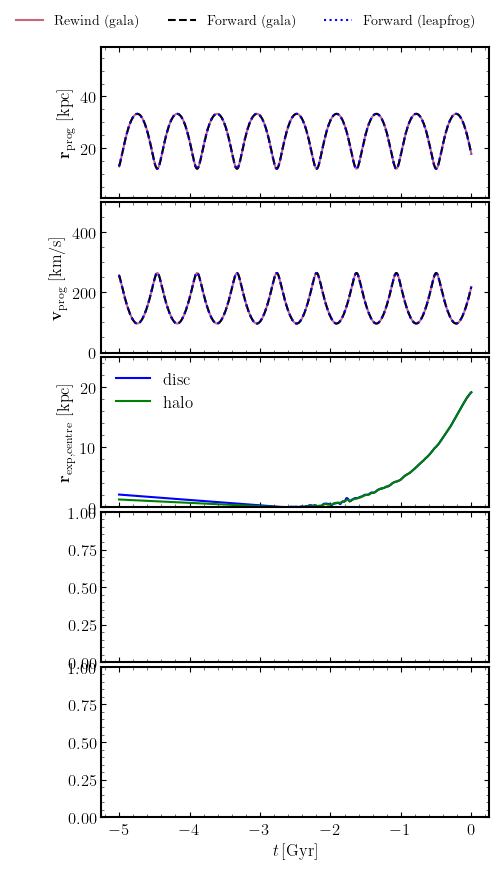

In [65]:
fig, ax = plt.subplots(5,1, figsize=(5,10), sharex='col')
plt.subplots_adjust(hspace=0.03,)

plt.sca(ax[0])
plt.plot(prog_rewind_orbit[2], np.linalg.norm(prog_rewind_orbit[0].T,axis=1).value, label='Rewind (gala)')
plt.plot(ts, np.linalg.norm(xs.T, axis=1), ls='--',label='Forward (gala)',c='k')
plt.plot(plot_ts, np.linalg.norm(progxs, axis=1), ls='dotted',label='Forward (leapfrog)',c='b')
plt.ylim(1,59)

plt.legend(ncol=3, frameon=False, fontsize=10, bbox_to_anchor=(1., 1.3))
plt.ylabel('$\mathbf{r}_{\mathrm{prog}}$ [kpc]')

plt.sca(ax[1])
plt.plot(prog_rewind_orbit[2], np.linalg.norm(prog_rewind_orbit[1].T,axis=1).to(u.km/u.s), label='Rewind (gala)' )
plt.plot(ts, np.linalg.norm(vs.T, axis=1), ls='--',label='Forward (gala)',c='k')
plt.plot(plot_ts, np.linalg.norm(progvs, axis=1), ls='dotted',label='Forward (leapfrog)',c='b')
plt.ylim(0,500)

plt.xlabel('$t$ [Gyr]')
plt.ylabel('$\mathbf{v}_{\mathrm{prog}}$ [km/s]')

plt.sca(ax[2])
plt.plot(prog_rewind_orbit[-1], np.linalg.norm(mwd_centers,axis=1), label='disc', c='b')
plt.plot(prog_rewind_orbit[-1], np.linalg.norm(mwh_centers,axis=1), label='halo', c='g')
# plt.plot(prog_rewind_orbit[-1], np.linalg.norm(lmc_centers,axis=1), label='lmc', c='r')
plt.ylim(0,25)
plt.ylabel(r'$\mathbf{r}_{\mathrm{exp,centre}}$ [kpc]')
plt.legend(frameon=False)

# plt.sca(ax[3])
# plt.plot(plot_ts, tidal_radii, marker="o",c='k',ls="none",alpha=0.5,mew=0,ms=1.5,)
# plt.ylim(0,5*np.median(tidal_radii))
# plt.ylabel(r'$r_{t}\,[\mathrm{kpc}]$')

plt.sca(ax[4])
# plt.plot(plot_ts,sigma_vs, marker="o",c='k',ls="none",alpha=0.5,mew=0, ms=1.5,)
# plt.hlines((((G.to(u.kpc*(u.km/u.s)**2/u.Msun)*31497.51414563594*u.Msun) / (np.median(tidal_radii)*u.kpc)).value)**0.5, 
#            -6,0,color='r', label=r'$\sqrt{GM_{prog}/\bar{r_t}}$')
# plt.xlim(-5.1,0.1)
plt.xlabel(r'$t\,[\mathrm{Gyr}]$')
# plt.ylabel(r'$\sigma_{v}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')
# plt.legend(frameon=False, fontsize=10)

plt.show()

# # plt.savefig('figures/example-fullexps-NOdisc')

Text(0, 0.5, '$\\mathrm{lat}\\,[^{\\circ}]$')

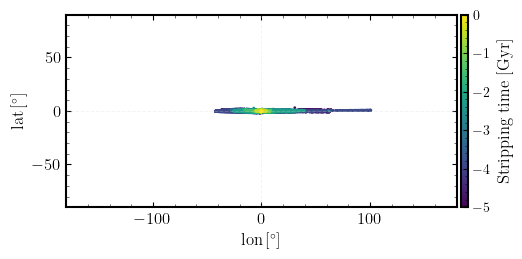

In [66]:
t_idx = -1

fig, ax = plt.subplots(1,1, sharex='col', sharey='row', figsize=(6,2.5))

prog = gd.PhaseSpacePosition(xs_myleap[t_idx, 0]* u.kpc, vs_myleap[t_idx,0]* u.km / u.s)
stream = gd.PhaseSpacePosition(xs_myleap[t_idx,1:].T * u.kpc, vs_myleap[t_idx,1:].T * u.km / u.s)
start_times = ts2

#-------------------------------------------------------------------------------------
### Rotation matrix for progenitor to get it to near (X, 0, 0)
#-------------------------------------------------------------------------------------
R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
R_prog0 = R2.as_matrix() @ R1.as_matrix()  
#-------------------------------------------------------------------------------------
### Rotate around new x axis so stream prog vel points along +y direction
#-------------------------------------------------------------------------------------
new_vxyz = R_prog0 @ prog.v_xyz
v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
R = (R3 * R2 * R1).as_matrix()
#-------------------------------------------------------------------------------------
### Rotate the whole stream by the final rotation matrix
#-------------------------------------------------------------------------------------
prog_rot = gd.PhaseSpacePosition(prog.data.transform(R))
prog_sph = prog_rot.spherical
stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
stream_sph = stream_rot.spherical
#-------------------------------------------------------------------------------------
### Plot the streams
#-------------------------------------------------------------------------------------

ax.hlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7, alpha=.25)
ax.vlines(0, -200, 200, ls='dashed', color='lightgrey', lw=0.7, alpha=.25)

lons = stream_sph.lon.wrap_at(180*u.deg).degree
lats =  stream_sph.lat.degree

plot=plt.scatter(lons, lats, s=1 , c=start_times, cmap = 'viridis',rasterized=True)
# ax.scatter(prog_sph.lon.wrap_at(180*u.deg).degree, prog_sph.lat.degree, s=100, edgecolors='k', facecolor='orange',marker='*', label='Prog.', rasterized=True)

cb = fig.colorbar(plot,  ax=ax, location='right', aspect=30, pad=0.01)
cb.set_label('Stripping time [Gyr]')
# cb.set_label('Closest approach to LMC \n [kpc]')
cb.ax.tick_params(labelsize=10)

ax.set_xlim(-180,180)
ax.set_ylim(-90,90)
ax.set_xlabel(r'$\mathrm{lon}\,[^{\circ}]$')
ax.set_ylabel(r'$\mathrm{lat}\,[^{\circ}]$')

In [16]:
def local_veldis(lons, vfs):
    # Compute percentiles
    lower_value = np.nanpercentile(lons, 0.1)
    upper_value = np.nanpercentile(lons, 99.9)
    # Filter lons_mainbody
    lons_mainbody = lons[(lons >= lower_value) & (lons <= upper_value)]
    vfs_mainbody = vfs[1:][(lons >= lower_value) & (lons <= upper_value)] #excludes progenitor [1:]
    # Create bins
    lon_bins = np.linspace(np.nanmin(lons_mainbody), np.nanmax(lons_mainbody), 50)
    # Compute absolute velocity norms
    vfs_absol = np.linalg.norm(vfs_mainbody, axis=1)
    # Slice lons_mainbody into bins
    bin_indices = np.digitize(lons_mainbody, lon_bins)
    # Create a mask array
    mask = np.zeros((len(lons_mainbody), len(lon_bins) - 1), dtype=bool)
    for i in range(1, len(lon_bins)):
        mask[:, i - 1] = (bin_indices == i)

    # Calculate standard deviation for each bin
    local_veldis = np.array([np.std(vfs_absol[m]) for m in mask.T])
    return np.nanmedian(local_veldis)

In [17]:
local_veldis(lons, vs_myleap[-1])

1.3025644135139653

In [18]:
np.nanstd(np.linalg.norm(vs_myleap[-1],axis=1))

9.264409047669087

3D movie of the stream generation

In [22]:
torb, lmcx, lmcy, lmcz = Model.get_lmc_trajectory(rewindtime=5., dt=0.001).T
ts_lmc, lmcxs, lmcys, lmczs = np.flip(torb[::50]), np.flip(lmcx[::50]) ,np.flip(lmcy[::50]), np.flip(lmcz[::50])

In [23]:
for t in ts_lmc:
    discframe = Model.expansion_centres(t)[9:12]
    lmcxs, lmcys, lmczs = lmcxs - discframe[0], lmcys - discframe[1], lmczs - discframe[2]

In [24]:
timestamps = ts2[::50][::2]
progxs, progvs = xs_myleap[:,0], vs_myleap[:,0]

In [28]:
timestamps.shape, ts_lmc.shape

((101,), (100,))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.clear()
    
    ax.plot(progxs[::50][:frame+1][:, 0], 
               progxs[::50][:frame+1][:, 1], 
               progxs[::50][:frame+1][:, 2], color='k', alpha=.25, label='prog orbit')
    ax.scatter(xs_myleap[::50][frame][:, 0], 
               xs_myleap[::50][frame][:, 1], 
               xs_myleap[::50][frame][:, 2], 
               marker='o', c='k', s=.5, rasterized=True)
    ax.scatter(0, 0, 0, s=25, edgecolors='k', facecolor='r', marker='*', label='Box center')
    ax.scatter(12.46554427, 19.2548966 , -3.21839009, s=25, edgecolors='k', facecolor='orange', marker='*', label='Prog. ic')
  
    ax.plot(lmcxs[:frame+1], 
            lmcys[:frame+1], 
            lmczs[:frame+1], color='b', label='lmc orbit')
    ax.scatter(lmcxs[frame], 
               lmcys[frame], 
               lmczs[frame], s=25, edgecolors='k', facecolor='b', marker='*')

    ax.set_xlim(-79,79)
    ax.set_ylim(-79,79)
    ax.set_zlim(-79,79)
    ax.set_xlabel(r'$x$ [kpc]')
    ax.set_ylabel(r'$y$ [kpc]')
    ax.set_ylabel(r'$z$ [kpc]')
    ax.view_init(azim = -60, elev = 30) #azim,: -60, 60

    ax.legend(frameon=False, ncol=2, fontsize=8)
    ax.set_title(r'$t = {}$ Gyr'.format(np.round(timestamps[frame], 2)))

ani = animation.FuncAnimation(fig, update, frames=len(timestamps), interval=2000)


writer = animation.PillowWriter(fps=3)
# ani.save('movies/test-stream550-rm-mwh-full-mwd-full-lmc.gif', writer=writer)
# ani.save('movies/test-stream550-static-mwh-only.gif', writer=writer)
ani.save('movies/test.gif', writer=writer)

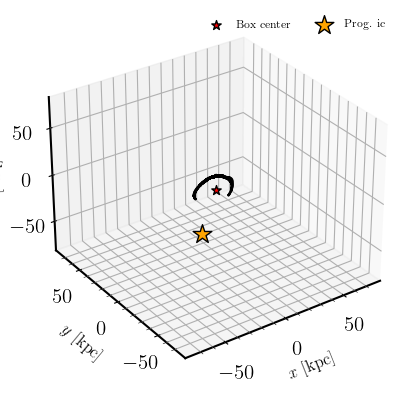

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# ax.plot(progxs[:-1][:frame+1][:, 0], 
#            progxs[-1][:frame+1][:, 1], 
#            progxs[-1][:frame+1][:, 2], color='k', alpha=.25, label='prog orbit')
ax.scatter(xs_myleap[-1][:, 0], 
           xs_myleap[-1][:, 1], 
           xs_myleap[-1][:, 2], 
           marker='o', c='k', s=.5, alpha=.25,rasterized=True)
ax.scatter(0, 0, 0, s=50, edgecolors='k', facecolor='r', marker='*', label='Box center')

ax.scatter(-2.31935584e+01, -1.58525434e+01, -2.63753505e+01, s=200, edgecolors='k', facecolor='orange', marker='*', label='Prog. ic')

ax.set_xlim(-79,79)
ax.set_ylim(-79,79)
ax.set_zlim(-79,79)
ax.set_xlabel(r'$x$ [kpc]')
ax.set_ylabel(r'$y$ [kpc]')
ax.set_zlabel(r'$z$ [kpc]')
ax.view_init(azim = -125, elev = 30) #azim,: -60, 60

ax.legend(frameon=False, ncol=2, fontsize=8)


# Compare to Gala

In [61]:
import gala.integrate as gi
import gala.dynamics as gd
from gala.units import galactic

In [69]:
import gala.integrate as gi
import gala.dynamics as gd
from gala.units import galactic

def gala_F(t, w, flags):
    t = t / 1e3  # Myr -> Gyr
    x0 = np.array(Model.expansion_centres(t))
    # disk
    acc_disk = Model.mwd_fields(t, *(w[:3, :] - x0[:3, None]), mwdharmonicflag=flags['d'])[:, :3]
    
    # halo
    acc_halo = Model.mwhalo_fields(t, *(w[:3] - x0[3:6, None]), mwhharmonicflag=flags['h'])[:, :3]
    
    # lmc
    acc_lmc = Model.lmc_fields(t, *(w[:3] - x0[6:9, None]), lmcharmonicflag=flags['lmc'])[:, :3]
    
    accs = (acc_disk + acc_halo + acc_lmc) * (u.km**2/(u.s**2*u.kpc))
    accs = accs.decompose(galactic).value
    return np.vstack((w[3:], accs.T))


# flags = {'d': 63, 'h': 63, 'lmc': 63}

# integrator = gi.LeapfrogIntegrator(gala_F, func_units=galactic, func_args=(flags,))
# # integrator = gi.Ruth4Integrator(gala_F, func_units=galactic, func_args=(flags,))

# w0 = gd.PhaseSpacePosition(
#     pos=[8., 0, 0] * u.kpc + mwd_x0 * u.kpc,
#     vel=[0, -190, 0] * u.km/u.s + mwd_v0 * u.km/u.s
# )

# orbit = integrator.run(w0, dt=-2, t1=0, t2=-5*u.Gyr)

# subtract these off
# disk_x0 = np.array([Model.expansion_centres(t)[:3] for t in orbit.t.to_value(u.Gyr)])
# disk_v0 = np.array([Model.expansion_centre_velocities(t)[:3] for t in orbit.t.to_value(u.Gyr)])

In [70]:
flags = {'d': 63, 'h': 63, 'lmc': 63}

integrator = gi.LeapfrogIntegrator(gala_F, func_units=galactic, func_args=(flags,))
# integrator = gi.Ruth4Integrator(gala_F, func_units=galactic, func_args=(flags,))

In [71]:
mwd_x0 = Model.expansion_centres(0.)[:3]
mwd_v0 = Model.expansion_centre_velocities(0.)[:3]

In [72]:
w0 = gd.PhaseSpacePosition(
    pos=[8., 0, 0] * u.kpc + mwd_x0 * u.kpc,
    vel=[0, -190, 0] * u.km/u.s + mwd_v0 * u.km/u.s
)

In [73]:
w0.w(galactic)

array([[ 9.77588840e+00],
       [ 1.90459035e+01],
       [-8.53029450e-01],
       [ 4.59085273e-03],
       [-1.77624148e-01],
       [ 3.69013554e-04]])

In [74]:
gala_F(0., w0.w(galactic), flags)

array([[ 4.59085273e-03],
       [-1.77624148e-01],
       [ 3.69013554e-04],
       [-3.04301125e-03],
       [-1.08451499e-05],
       [-6.23844452e-05]])

In [75]:
orbit = integrator.run(w0, dt=-2, t1=0, t2=-5*u.Gyr)

In [76]:
disk_x0 = np.array([Model.expansion_centres(t)[:3] for t in orbit.t.to_value(u.Gyr)])
disk_v0 = np.array([Model.expansion_centre_velocities(t)[:3] for t in orbit.t.to_value(u.Gyr)])

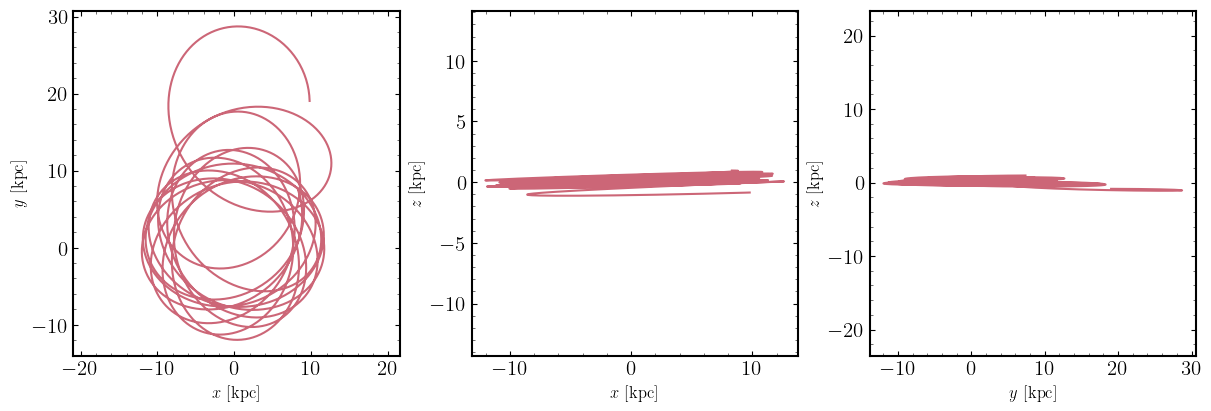

In [77]:
orbit.plot();

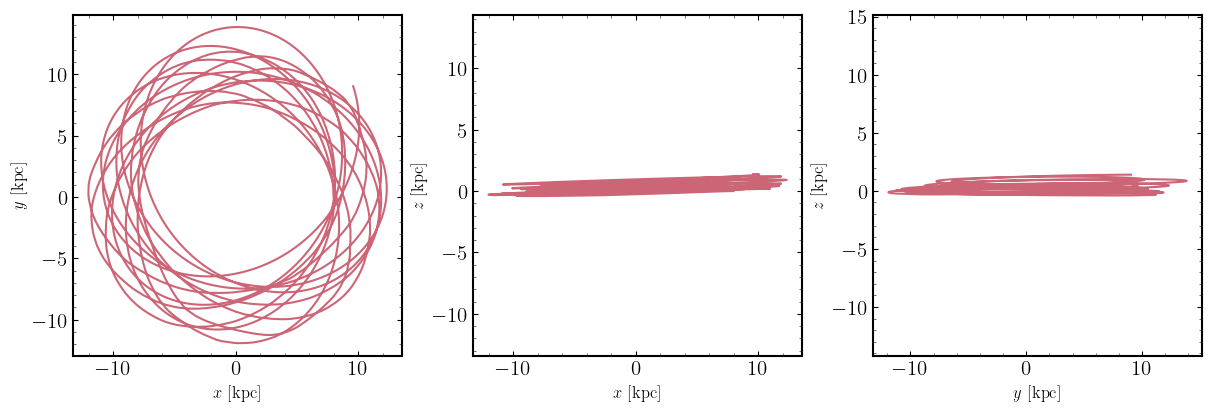

In [78]:
orbit_disk_frame = gd.Orbit(
    pos=orbit.xyz - disk_x0.T * u.kpc,
    vel=orbit.v_xyz - disk_v0.T * u.km/u.s ,
    t=orbit.t
)

orbit_disk_frame.plot();

